## Application of Aging Index

## Notebook description
Application of mobility index developed using WEDS extract to differentiate between mobility vs healthy pets on WAM study.

## Input data
1) AGING_DATA_EXTRACT_NEW_NQSD_20231214.csv

In [1]:
import sys
import scipy
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from decimal import Decimal
from matplotlib.pylab import plt

from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
import os, sys
scripts_master = os.path.dirname('../../advanced_stats_code_library/src/')
sys.path.insert(0, scripts_master) 

from norm_excursion.report_results import ReportResults
from norm_excursion.norm_excursion import NormExcursion
from norm_excursion.study_meta_data import StudyMetaData
from norm_excursion.data_validation import DataValidation
from responder_analysis import responder_utils
from responder_analysis.responder_analysis import ResponderAnalysis
from statsmodels.stats.proportion import proportion_confint
from power_analysis.power_analysis import PowerAnalysis
from scipy import stats
power_analysis=PowerAnalysis()
import warnings
warnings.filterwarnings('ignore')
palette = sns.color_palette('deep', 10)
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
params = {
            'legend.fontsize': 'x-large',
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'
        }
plt.rcParams.update(params)

## Load data

In [2]:
data_nopop = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/AGING_DATA_EXTRACT__NEW_NQSD_20231214.csv")
population = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/population_updates_20231214.csv")

In [3]:
data = pd.merge(data_nopop, population, on=['PET_ID'], how='left')

In [4]:
# Rename the dataset name to correpond with the source library
data['external_patient_id'] = data['EXTERNAL_ID']
data['study_group'] = data['study_food']

In [5]:
aging = data[data['IS_QUALIFIED_NEW'] == 'YES']
aging['unique_patient_date'] = aging['external_patient_id'] +'_'+ aging['DATE'].astype(str)
aging_df = aging[aging['study_food'].notna() & aging['NORMALIZED_QUALIFYING_STUDY_DAY_NEW'].notna()]
aging_df = aging_df.drop(['COMPLETION_DATE', 'DAILYDATAQUALITYINDREASON'], axis=1)
#creating period variable
aging_df['period'] = aging_df['NORMALIZED_QUALIFYING_STUDY_DAY_NEW'].apply(
    lambda x: 'baseline' if x < 0 else 'treatment'
)
treatment_counts = aging_df[aging_df['period'] == 'treatment'].groupby('EXTERNAL_ID').size()
baseline_counts = aging_df[aging_df['period'] == 'baseline'].groupby('EXTERNAL_ID').size()

# Filtering out PET_IDs where the 'treatment' period is less than 28 days and 'baseline' period is less than 21 days
filtered_pet_ids = treatment_counts[(treatment_counts >= 63) & (baseline_counts >= 21)].index
new_aging_df = aging_df[aging_df['EXTERNAL_ID'].isin(filtered_pet_ids)]


## Responder analysis parameters

In [6]:
# Parameters
feature_columns=['Walking_ACE_All_day', 'active_900', 'Resting_CE_6pm_12am', 'Running_ACE_6pm_12am', 'Sleeping_TD_6pm_12am']
# Response direction (increase or decrease)
response_direction='decrease'
# Success percent
success_percent=10
# Number of weeks and days
no_of_weeks=12
no_of_days=no_of_weeks*7
# Significance level for hypothesis testing
significance_level=0.05
# Study day variable
study_day='NORMALIZED_QUALIFYING_STUDY_DAY_NEW'
# Group 1 (yellow) and Group 2 (pink) names
group_1_names=new_aging_df[new_aging_df['study_group']==\
                                    'Black']['external_patient_id'].unique()
group_2_names=new_aging_df[new_aging_df['study_group']==\
                                    'Peach']['external_patient_id'].unique()
# Loading mobility index created earlier using model file
mobility_index = CatBoostClassifier()

mobility_index.load_model("aging_index_top_5_features")

In [7]:
def rename_columns(df):
    """ 

    The function 'rename_columns' is used for rename the feature columns into meaningful activity columns.

    Parameters
    ----------
    df : str
        The dataframe which contains the feature columns.
  
    """ 
    replace_dict_activity = {

        '_12': 'Sleeping',
        '_1': 'Resting',
        '_3': 'Running',
        '_5': 'Scratching',
        '_4': 'Shaking',
        '_2': 'Walking'
    }

    replace_dict_time = {
        'Q1': '12am_6am',
        'Q2': '6am_12pm',
        'Q3': '12pm_6pm',
        'Q4': '6pm_12am',
        'Q5': 'All_day'
    }

    # New column names
    new_cols = []

    for col in df.columns:
        # Initialize activity
        activity = ''

        # If the column doesn't start with 'VAR' or 'DER', add it to new_cols without conversion
        if not col.startswith('VAR') and not col.startswith('DER'):
            new_cols.append(col)
            continue

        # Remove the _1 at last
        if col.endswith('_2'):
            col = col[:-2]

        # Replace activity codes with names
        for old, new in replace_dict_activity.items():
            if old in col:
                col = col.replace(old, '')
                activity = new
                break

        # Remove 'VAR' or 'DER'
        if col.startswith('VAR'):
            col = col[3:]
        elif col.startswith('DER'):
            col = col[3:]

        # Replace time codes with names
        for old, new in replace_dict_time.items():
            if old in col:
                col = col.replace(old, new)
                break

        # Place the replaced part (activity) at the beginning
        col = activity + col

        new_cols.append(col)

    df.columns = new_cols
    
    return df

In [8]:
new_aging_df = rename_columns(new_aging_df)

## Index applied to Aging

In [9]:
meta_columns=['external_patient_id', study_day,
              'study_group']

response_from_baseline=[]
baseline_append=[]
# Looping through each patient and creating model per patient
for patient_name in new_aging_df['external_patient_id'].unique():
    features_tinker=meta_columns+feature_columns
    sample_patient=new_aging_df[new_aging_df\
                                          ['external_patient_id']==patient_name]\
                                                        [features_tinker]\
                                                        .reset_index()\
                                                        .drop(['index'],axis=1)
    sample_patient.index=sample_patient[study_day]
    
    # Baseline period
    baseline_period=sample_patient[(sample_patient[study_day]<0) & (sample_patient[study_day]>=-21)]
    # Treatment period
    treatment_period=sample_patient[(sample_patient[study_day]>=0) & (sample_patient[study_day]<=63)]
    
    # application of mobility index on baseline period
    baseline_period['baseline_proba']=mobility_index.predict_proba(baseline_period[feature_columns])[:,1]
    
    baseline_mean=baseline_period['baseline_proba'].mean()
    baseline_std=baseline_period['baseline_proba'].std()
    # % change of mobility index from baseline to treatment
    treatment_period['treatment_proba']=mobility_index.predict_proba(treatment_period[feature_columns])[:,1]
    treatment_period['treatment_proba']=(treatment_period['treatment_proba']-baseline_mean)/baseline_std
    treatment_period['% Increase run/walk']=((treatment_period['treatment_proba']-baseline_mean)\
                                               /baseline_mean).values*100
    # appending results
    response_from_baseline.append(treatment_period[['external_patient_id',
                                                    study_day,\
                                                    '% Increase run/walk','treatment_proba']])
    baseline_append.append(baseline_period)

response_from_baseline_df=pd.concat(response_from_baseline)
# daily success matrix with patients as columns and values as % change
daily_success_matrix=response_from_baseline_df.pivot(index=study_day, \
                                            columns='external_patient_id', \
                                            values='% Increase run/walk')
response_matrix=daily_success_matrix.copy()
# weekly patient analysis
weekly_patient_analysis=[]
for x in response_matrix.columns:
    flatten_decrease=pd.DataFrame(response_matrix[x].values.flatten())\
                .dropna().reset_index().drop(['index'],axis=1)
    i=0
    week_decrease=[]
    for i, g in flatten_decrease.groupby(np.arange(len(flatten_decrease)) // 7):
        i+=1
        if g.shape[0]==7:
            if response_direction=='increase':
                week_decrease.append([i,g[g>success_percent].count().values[0]/7])
            elif response_direction=='decrease':
                week_decrease.append([i,g[g<-success_percent].count().values[0]/7])
                
    weekly_success=pd.DataFrame(week_decrease)
    weekly_success.columns=['week_name','percent_of_success_days']
    weekly_success['external_patient_id']=x
    weekly_patient_analysis.append(weekly_success)
weekly_success_matrix=pd.concat(weekly_patient_analysis)\
                    .pivot(index='week_name', 
                            columns='external_patient_id', \
                            values='percent_of_success_days')

In [10]:
# Parameters for binomial test
group_1_flat=pd.DataFrame(daily_success_matrix[group_1_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
group_2_flat=pd.DataFrame(daily_success_matrix[group_2_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
if response_direction == 'increase':
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]
elif response_direction == 'decrease':
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]

In [11]:
total_number_of_trial_group_1

1980

In [12]:
total_number_of_trial_group_2

2041

## Results

In [13]:
# z test 
z_test_p_value=responder_utils.z_test(success_count_group_1/total_number_of_trial_group_1,\
                      success_count_group_2/total_number_of_trial_group_2,\
                      total_number_of_trial_group_1,\
                      total_number_of_trial_group_2)

# Binomial confidence interval
binomial_confidence_interval=responder_utils.binomial_confidence_interval(daily_success_matrix,
                                             group_1_names,
                                             group_2_names,
                                             no_of_days,
                                             response_direction,
                                             success_percent,
                                             significance_level)

# Difference of mean tests
group_1_means, group_2_means=responder_utils.proportion_per_patient(response_from_baseline_df,
                           '% Increase run/walk',
                           response_direction,
                           success_percent,
                           study_day,
                           group_1_names,
                           group_2_names,
                           no_of_days)

In [14]:
group_1_means

[0.96875,
 0.828125,
 0.46875,
 0.578125,
 0.546875,
 0.3125,
 0.765625,
 0.78125,
 0.84375,
 0.765625,
 1.0,
 0.796875,
 0.6825396825396826,
 0.9523809523809523,
 1.0,
 0.9206349206349206,
 0.84375,
 0.9375,
 0.71875,
 0.65625,
 0.640625,
 0.8125,
 0.8125,
 0.4375,
 0.71875,
 0.75,
 0.609375,
 0.828125,
 0.703125,
 0.5238095238095238,
 0.765625]

----------------------------------------------------
Binomial test results:

Binomial test for difference in proportion:

P-value: 0.2860884805945476


Binomial confidence interval:

Group 1 (yellow): (0.7216105690967202, 0.7602076127214618)
Group 2 (pink): (0.7368664176386734, 0.774157590200621)
----------------------------------------------------
Difference in means results:

Effect size: -0.08278482481871408


T-test:

                       T-test Assumptions                      
                                          Success/Fails P-value
---------------------------------------------------------------
1) Test for equality of variance (levene)       Success  0.9144
2) Test for normality (shapiro)                   Fails        
 a) Group 1                                              0.3742
 b) Group 2                                              0.0382
---------------------------------------------------------------
Levene test
The Levene test tests the null hypothesis that all

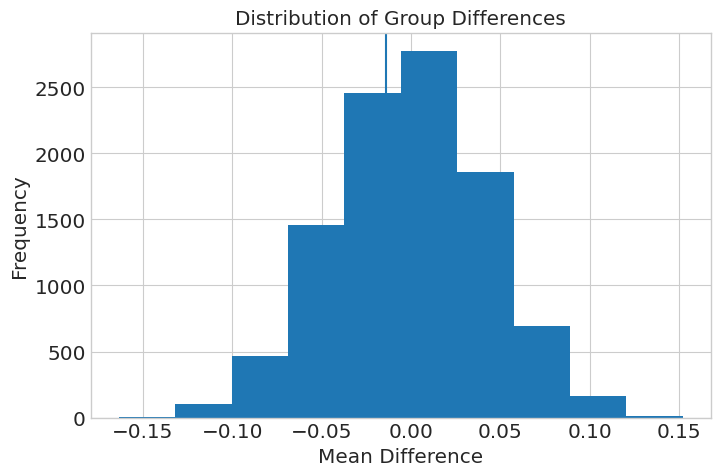

In [15]:
print("----------------------------------------------------")
print('\033[1m'+"Binomial test results:\n"+"\033[0;0m")
print("Binomial test for difference in proportion:\n")
print("P-value:",z_test_p_value)
print("\n")

print("Binomial confidence interval:\n")
print("Group 1 (yellow):",binomial_confidence_interval[0])
print("Group 2 (pink):",binomial_confidence_interval[1])
print("----------------------------------------------------")
print('\033[1m'+"Difference in means results:\n"+"\033[0;0m")
print("Effect size:",power_analysis.get_cohend_effectsize(group_1_means,
                                                         group_2_means))
print("\n")
print("T-test:\n")
responder_utils.t_test(group_1_means,
                      group_2_means,
                      0.05,
                      display=True)
print("Mann whitney test: ",stats.mannwhitneyu(group_1_means,group_2_means))
responder_utils.randomization_test(group_1_means, group_2_means, 
                   10000, 0.05,False)

In [16]:
# colors for weekly plot
group_1_color='black'
group_2_color='#FFCBA4'
group_one_name='Black'
group_two_name='Peach'

## Weekly confidence interval plot

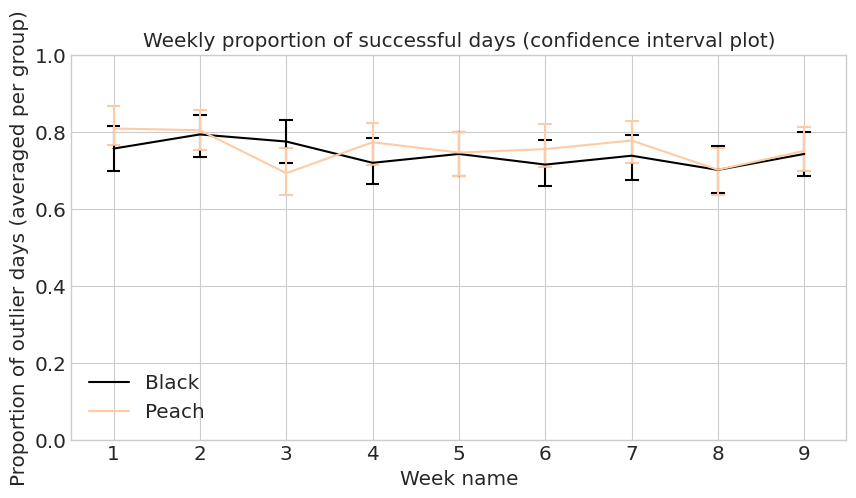

In [17]:
responder_utils.weekly_confidence_interval_plot(daily_success_matrix,
                                    weekly_success_matrix,
                                    group_1_names, group_2_names,
                                    'decrease',
                                    success_percent,
                                    significance_level,
                                    no_of_weeks,
                                    group_1_color, group_2_color,
                                    group_one_name, group_two_name)